In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

from tqdm import tqdm
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

2022-08-20 18:09:46.247182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-20 18:09:46.247208: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

https://medium.com/@majpaw1996/anomaly-detection-in-computer-vision-with-ssim-ae-2d5256ffc06b
https://github.com/SubhamIO/AnomalyDetection---Deep-AUTOENCODERS

In [64]:
train_path = "../../data/chest_xray/chest_xray/train"
test_path = "../../data/chest_xray/chest_xray/test"
val_path = "../../data/chest_xray/chest_xray/val"

In [65]:
def displayer(X_tr, X_tr_ae):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(1, n + 1):
        # Display original
        ax = plt.subplot(2, n, i)
        plt.imshow(X_tr[i].reshape(64, 64, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(X_tr_ae[i].reshape(64, 64,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [66]:
dsize =(64, 64)

labels = {"NORMAL":0, "PNEUMONIA":1}

In [67]:
def load_images(dir_path, labels, dsize = (32, 32)):
    """loading images"""
    X_image, y_image = [], []
    for label_name, Id in labels.items():
        for jpeg in tqdm(os.listdir(os.path.join(dir_path, label_name))):
            path = os.path.join(dir_path, label_name, jpeg)
            image = load_img(path, target_size=dsize)
            X_image.append(image)
            #self.X_image.append(img_to_array(image)/255.0)
            y_image.append(Id)
    return X_image, y_image

def display_images(X, y, figure_row=4, figure_cols=4):
    """Display images """
    f, ax = plt.subplots(nrows= figure_row, ncols=figure_cols, 
                         figsize=(figure_row*figure_cols, figure_row*figure_cols)) 
    number_of_images = figure_row * figure_cols
    img = []
    for i in range(figure_row):
        for j in range(figure_cols):
            while True:
                rand = np.random.randint(0, len(X)-1)
                if rand not in img:
                    img.append(rand)
                    break
            image=X[rand]#cv2.imread(self.path_lsts[rand])
            ax[i, j].imshow(image, resample=True, cmap='gray')
            ax[i, j].set_title("Class-"+ str(y[rand]), fontsize=16)
    plt.tight_layout()
    plt.show()
    print

In [68]:
X_train_org, y_train = load_images(train_path, labels, dsize = dsize)

X_test_org, y_test = load_images(test_path, labels, dsize = dsize)

X_val_org, y_val = load_images(val_path, labels, dsize = dsize)

100%|██████████| 8/8 [00:00<00:00, 357.19it/s]


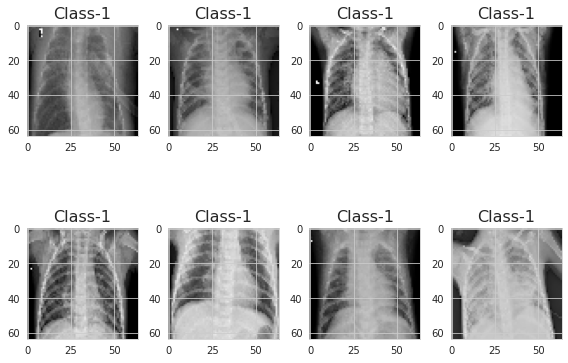

In [69]:
display_images(X_train_org, y_train, figure_row=2, figure_cols=4)

In [70]:
def preprocess_images(images, y, normalize = True):
    X = []
    for i in tqdm(range(len(images))):
        img = img_to_array(images[i]).astype('float32')
        if normalize:
            img = img/255.0
        X.append(img)
    #Shuffle data
    dataset = list(zip(X, y))
    random.shuffle(dataset)

    X, y = zip(*dataset)
    return np.array(X), np.array(y)

In [71]:
normalize = True

x_train, y_train =preprocess_images(X_train_org, y_train, normalize=normalize)
print("Shape of X_train:", x_train.shape)

x_val, y_val =preprocess_images(X_val_org, y_val, normalize=normalize)
print("Shape of X_val:", x_val.shape)

x_test, y_test =preprocess_images(X_test_org, y_test, normalize=normalize)
print("Shape of X_test:", x_test.shape)

100%|██████████| 5216/5216 [00:00<00:00, 23901.10it/s]


Shape of X_train: (5216, 64, 64, 3)


100%|██████████| 16/16 [00:00<00:00, 14438.22it/s]


Shape of X_val: (16, 64, 64, 3)


100%|██████████| 624/624 [00:00<00:00, 29943.55it/s]

Shape of X_test: (624, 64, 64, 3)


In [72]:
np.max(x_train), np.max(x_val), np.max(x_test) 

(1.0, 1.0, 1.0)

In [73]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape 

((5216, 64, 64, 3), (5216,), (16, 64, 64, 3), (16,), (624, 64, 64, 3), (624,))

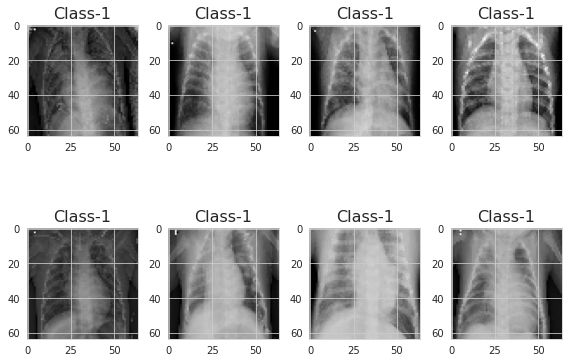

In [74]:
display_images(x_train, y_train, figure_row=2, figure_cols=4)

In [48]:
# Create the Encoder and Decoder#pass the gray scale input image of size(28,28,1)
inputs = tf.keras.Input(shape=(128, 128, 3), name='input_layer')
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# output
outputs = tf.keras.layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

In [76]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [49]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)

In [18]:
# Clear previous logs
!rm -rf "../../logs"
from keras.callbacks import TensorBoard

In [17]:
!ls "../../logs"

train  validation


In [50]:
hist=autoencoder.fit(x_train, x_train,
                epochs=15,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val),
                #callbacks=[TensorBoard(log_dir="../../logs")]
                )

Epoch 1/15
41/41 [==============================] - 90s 2s/step - loss: 0.3634 - val_loss: 0.6067
Epoch 2/15
41/41 [==============================] - 88s 2s/step - loss: 0.1374 - val_loss: 0.5899
Epoch 3/15
41/41 [==============================] - 89s 2s/step - loss: 0.1088 - val_loss: 0.5690
Epoch 4/15
41/41 [==============================] - 89s 2s/step - loss: 0.0899 - val_loss: 0.5303
Epoch 5/15
41/41 [==============================] - 89s 2s/step - loss: 0.0759 - val_loss: 0.4869
Epoch 6/15
41/41 [==============================] - 89s 2s/step - loss: 0.0658 - val_loss: 0.4335
Epoch 7/15
41/41 [==============================] - 89s 2s/step - loss: 0.0588 - val_loss: 0.3754
Epoch 8/15
41/41 [==============================] - 89s 2s/step - loss: 0.0512 - val_loss: 0.3263
Epoch 9/15
41/41 [==============================] - 89s 2s/step - loss: 0.0447 - val_loss: 0.2697
Epoch 10/15
41/41 [==============================] - 89s 2s/step - loss: 0.0408 - val_loss: 0.2126
Epoch 11/15
41/41 [

In [83]:
hist_cnnaue=cnnuae_autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val),
                #callbacks=[TensorBoard(log_dir="../../logs")]
                )

Epoch 1/10
41/41 [==============================] - 153s 4s/step - loss: 0.5003 - val_loss: 0.6327
Epoch 2/10
41/41 [==============================] - 151s 4s/step - loss: 0.3625 - val_loss: 0.6494
Epoch 3/10
41/41 [==============================] - 151s 4s/step - loss: 0.3349 - val_loss: 0.6649
Epoch 4/10
41/41 [==============================] - 151s 4s/step - loss: 0.3182 - val_loss: 0.6889
Epoch 5/10
41/41 [==============================] - 150s 4s/step - loss: 0.3065 - val_loss: 0.6797
Epoch 6/10
41/41 [==============================] - 150s 4s/step - loss: 0.3001 - val_loss: 0.6583
Epoch 7/10
41/41 [==============================] - 151s 4s/step - loss: 0.2926 - val_loss: 0.6382
Epoch 8/10
41/41 [==============================] - 151s 4s/step - loss: 0.2867 - val_loss: 0.6111
Epoch 9/10
41/41 [==============================] - 152s 4s/step - loss: 0.2835 - val_loss: 0.5489
Epoch 10/10
41/41 [==============================] - 151s 4s/step - loss: 0.2795 - val_loss: 0.4890


In [21]:
# %load_ext tensorboard
# %tensorboard --logdir="../../logs" #Specify the path in fit

In [84]:
decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

2022-08-20 20:48:29.705843: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_grad_input_ops.h:528 : INVALID_ARGUMENT: Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 16, computed = 32 spatial_dim: 1 input: 32 filter: 3 output: 16 stride: 1 dilation: 1


InvalidArgumentError: Graph execution error:

Detected at node 'model_1/conv_transpose_1/conv2d_transpose' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1163424/4102231875.py", line 1, in <cell line: 1>
      decoded_imgs = autoencoder.predict(x_test)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/layers/convolutional/conv2d_transpose.py", line 275, in call
      outputs = backend.conv2d_transpose(
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/backend.py", line 5756, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(x, kernel, output_shape, strides,
Node: 'model_1/conv_transpose_1/conv2d_transpose'
Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 16, computed = 32 spatial_dim: 1 input: 32 filter: 3 output: 16 stride: 1 dilation: 1
	 [[{{node model_1/conv_transpose_1/conv2d_transpose}}]] [Op:__inference_predict_function_697956]

In [85]:
ssim_normal_errors = []
ssim_pneumonia_errors = []
predictions = autoencoder.predict(x_test)

2022-08-20 20:48:38.066730: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_grad_input_ops.h:528 : INVALID_ARGUMENT: Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 16, computed = 32 spatial_dim: 1 input: 32 filter: 3 output: 16 stride: 1 dilation: 1


InvalidArgumentError: Graph execution error:

Detected at node 'model_1/conv_transpose_1/conv2d_transpose' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1163424/4102231875.py", line 1, in <cell line: 1>
      decoded_imgs = autoencoder.predict(x_test)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/layers/convolutional/conv2d_transpose.py", line 275, in call
      outputs = backend.conv2d_transpose(
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/backend.py", line 5756, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(x, kernel, output_shape, strides,
Node: 'model_1/conv_transpose_1/conv2d_transpose'
Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 16, computed = 32 spatial_dim: 1 input: 32 filter: 3 output: 16 stride: 1 dilation: 1
	 [[{{node model_1/conv_transpose_1/conv2d_transpose}}]] [Op:__inference_predict_function_697956]

In [53]:
len(predictions), predictions.shape, x_test.shape

(624, (624, 128, 128, 3), (624, 128, 128, 3))

In [54]:
for i in range(len(x_test)):
    value_a = SSIMLoss(predictions[i], x_test[i])
    if y_test[i] == 0:
        ssim_normal_errors.append(value_a)
    else:
        ssim_pneumonia_errors.append(value_a)

In [55]:
len(ssim_normal_errors), len(ssim_pneumonia_errors)

(234, 390)

In [62]:
np.mean(ssim_normal_errors), np.mean(ssim_pneumonia_errors)

(0.092013985, 0.09477979)

In [61]:
ssim_normal_errors[15], ssim_pneumonia_errors[15]

(<tf.Tensor: shape=(), dtype=float32, numpy=0.12417346>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.05973178>)

In [60]:
# pneumonia = 1, normal = 0
good = 0
bad = 0
for i in range(len(x_test)):
    value_a = SSIMLoss(predictions[i], x_test[i])
    if(value_a > 0.093):
        if(y_test[i] == 0):
            good = good + 1
        else:
            bad = bad + 1
    else:
        if(y_test[i] == 0):
            bad = bad + 1
        else:
            good = good + 1 

In [58]:
good, bad , good+bad, len(x_test)

(361, 263, 624, 624)

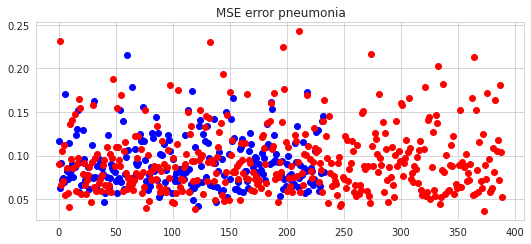

In [63]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.title("MSE error pneumonia")
plt.plot(ssim_normal_errors, 'bo')
plt.plot(ssim_pneumonia_errors, 'ro')

plt.show()

1/1 [==============================] - 0s 22ms/step


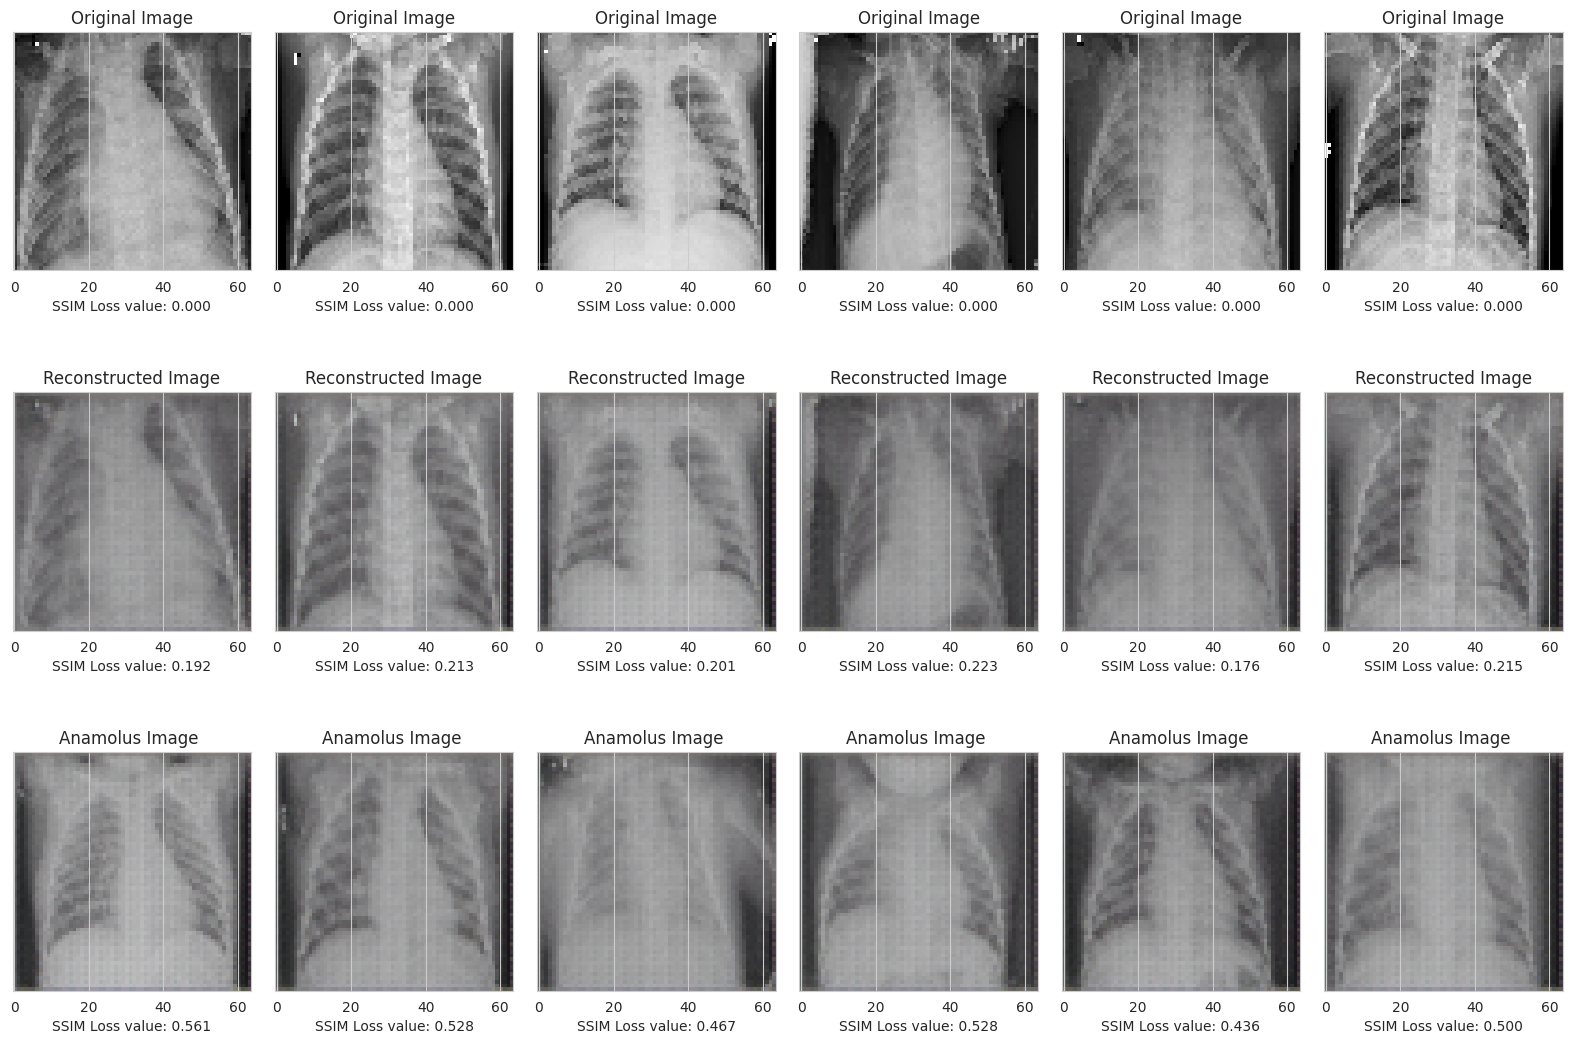

In [57]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display
decoded_imgs= autoencoder.predict(x_test)
decoded_mnistimgs= autoencoder.predict(x_val)
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(x_test[i], x_test[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(decoded_imgs[i], x_test[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(decoded_mnistimgs[i])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_mnistimgs[i], decoded_imgs[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.show()